## Analyze CDRs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


We want to create a DataFrame with columns

- chain_type: 'heavy' or 'light'
- ab_resnum
- ab_icode
- total_counts: how often does this residue occur in data set
- contact_counts: how often does this residue make contact to antigen in data set

In [3]:
acp = pd.read_csv("../generated/contacts/atomic_contacts.tsv", sep="\t")
res = pd.read_csv("../generated/contacts/residues.tsv", sep="\t")

In [4]:
acp.head()

,pdb_id,chain_type,ab_chain,ag_chain,ab_resnum,ab_icode,ab_resname,ab_atom,ag_resnum,ag_icode,ag_resname,ag_atom
0,3hi6,heavy,H,A,30.0,,SER,O,269.0,,GLU,C
1,3hi6,heavy,H,A,30.0,,SER,O,269.0,,GLU,O
2,3hi6,heavy,H,A,31.0,,ARG,C,241.0,,GLU,O
3,3hi6,heavy,H,A,31.0,,ARG,C,241.0,,GLU,O
4,3hi6,heavy,H,A,31.0,,ARG,C,241.0,,GLU,O


In [5]:
res.head()

,pdb_id,chain_type,ab_chain,ab_resnum,ab_icode,ab_resname
0,3hi6,heavy,H,1,,GLU
1,3hi6,heavy,H,2,,VAL
2,3hi6,heavy,H,3,,GLN
3,3hi6,heavy,H,4,,LEU
4,3hi6,heavy,H,5,,LEU


We can compute the number of residue contacts using grouping of the `acp` DataFrame.

We check per pdb_id and ab_resnum how many lines we have (here we count ag_resnum, but we could count any column). This is the number of atom contacts, as every line corresponds to an atom contact.

We also check how many unique ag_resnums we have. That is the number of contacts between different ag_resnums.

The grouping we have to use is (pdb_id, ab_resnum, ab_icode), 
The colums ab_chain, chain_type, and ab_resname are only for annotation purposes.

In [32]:
rcp = acp.groupby(['pdb_id', 'ab_chain','chain_type', 'ab_resnum', 'ab_icode', 'ab_resname']).agg(natomcontacts = ('ag_resnum', 'size'),
                                            nrescontacts = ('ag_resnum', 'nunique')).reset_index()

rcp["contact"] = 1   # always > 0, as we only have rows with atom contacts in acp

rcp.head()

,pdb_id,ab_chain,chain_type,ab_resnum,ab_icode,ab_resname,natomcontacts,nrescontacts,contact
0,1adq,H,heavy,1.0,,GLU,10,3,1
1,1adq,H,heavy,31.0,,ASP,17,3,1
2,1adq,H,heavy,52.0,A,TRP,11,2,1
3,1adq,H,heavy,96.0,,ARG,5,2,1
4,1adq,H,heavy,97.0,,SER,3,1,1


The data frame rcp now tells us if a (pdb_id, ab_resnum, ab_icode) has a contact to any antigen residue.

Now we want to look at how frequent  a given heavy chain (or light chain) residue has contact to a antigen residue.

So we need to get the total number of antibody residues (which could have a contact). We get this from the res data frame.


In [33]:
m = res.merge(rcp, how = "left", 
          on = ["pdb_id", "chain_type", "ab_chain", "ab_resnum", "ab_icode", "ab_resname"]
          ).fillna(0)

m = m.assign(ab_res = m["ab_resnum"].astype(str) + m["ab_icode"])

m.head()

,pdb_id,chain_type,ab_chain,ab_resnum,ab_icode,ab_resname,natomcontacts,nrescontacts,contact,ab_res
0,3hi6,heavy,H,1,,GLU,0.0,0.0,0.0,1
1,3hi6,heavy,H,2,,VAL,0.0,0.0,0.0,2
2,3hi6,heavy,H,3,,GLN,0.0,0.0,0.0,3
3,3hi6,heavy,H,4,,LEU,0.0,0.0,0.0,4
4,3hi6,heavy,H,5,,LEU,0.0,0.0,0.0,5


In [34]:
m.to_csv("../generated/contacts/residue_contacts_all.tsv", sep = "\t", index = False)

Now we can create a data frame where for every
- chain_type
- resnum
- icode

we compute 
- the total number of occurrences
- the total number of contacts

In [23]:
stats = m.groupby(["chain_type", "ab_resnum", "ab_icode"]).agg(nresidues = ("ab_resname", "size"),
                                                               ncontacts = ("contact", "sum"),
                                                               ).reset_index()
stats = stats.assign(ab_res = stats["ab_resnum"].astype(str) + stats["ab_icode"])

stats.head()
    

,chain_type,ab_resnum,ab_icode,nresidues,ncontacts,ab_res
0,heavy,1,,1033,69,1
1,heavy,2,,1312,108,2
2,heavy,3,,1357,6,3
3,heavy,4,,1366,1,4
4,heavy,5,,1367,3,5


In [31]:
sm = stats.melt(id_vars = ["chain_type", "ab_resnum", "ab_icode", "ab_res"], 
           var_name = "stat", value_name = "count")

sm.head()

,chain_type,ab_resnum,ab_icode,ab_res,stat,count
0,heavy,1,,1,nresidues,1033
1,heavy,2,,2,nresidues,1312
2,heavy,3,,3,nresidues,1357
3,heavy,4,,4,nresidues,1366
4,heavy,5,,5,nresidues,1367


Now we can look at the CDR regions

In [9]:
import seaborn as sns

<Axes: xlabel='ab_res', ylabel='count'>

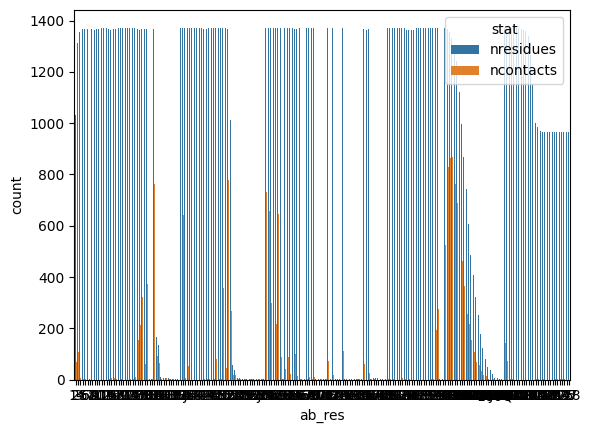

In [57]:
sns.barplot(data = sm.query("chain_type == 'heavy'"), 
            x = "ab_res", y = "count", hue = "stat")

<Axes: xlabel='ab_res', ylabel='count'>

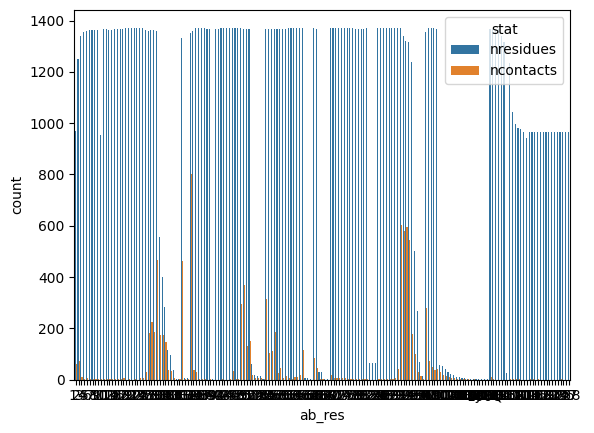

In [58]:
sns.barplot(data = sm.query("chain_type == 'light'"), 
            x = "ab_res", y = "count", hue = "stat")

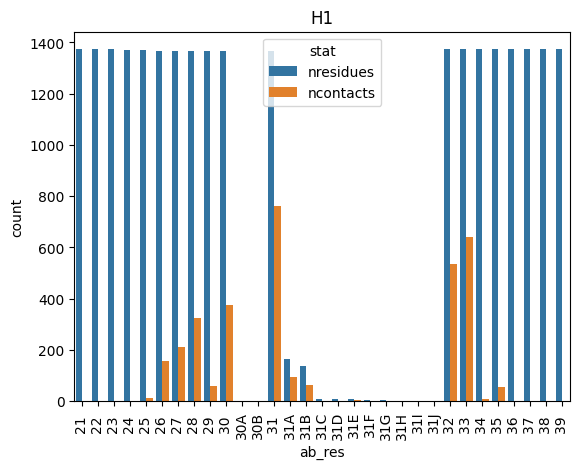

In [54]:
(sns
 .barplot(data = sm.query("chain_type == 'heavy' and 20 < ab_resnum < 40"), 
            x = "ab_res", y = "count", hue = "stat"))
plt.title ("H1")
plt.xticks(rotation=90)

#plt.tight_layout()
plt.show()


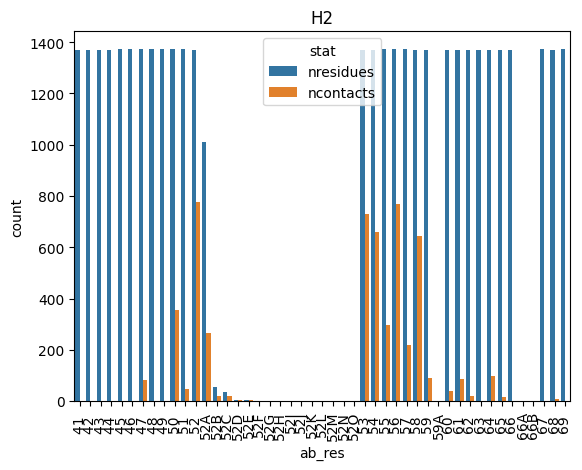

In [55]:
sns.barplot(data = sm.query("chain_type == 'heavy' and 40 < ab_resnum < 70"), 
            x = "ab_res", y = "count", hue = "stat")
plt.xticks(rotation=90)
plt.title("H2")
#plt.tight_layout()
plt.show()


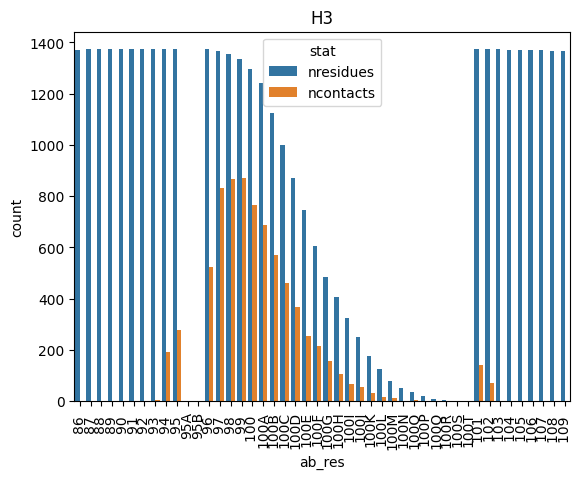

In [56]:
sns.barplot(data = sm.query("chain_type == 'heavy' and 85 < ab_resnum < 110"), 
            x = "ab_res", y = "count", hue = "stat")
plt.xticks(rotation=90)
plt.title("H3")
#plt.tight_layout()
plt.show()
